In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)
    
import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

c:\Users\Joaquin\Documents\GitHub\skforecast
0.20.0


In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import skforecast
from skforecast.stats import Sarimax, Arima
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset

from aeon.forecasting.stats import ARIMA as ARIMA_aeon
from statsforecast import StatsForecast
from statsforecast.models import ARIMA as ARIMA_statsforecast
import pmdarima as pm
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
print(f"skforecast version: {skforecast.__version__}")

skforecast version: 0.20.0


# Fuel consumption dataset

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=True, verbose=False)
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha': 'date', 'Gasolinas': 'y'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.loc[:'1990-01-01 00:00:00', ['y']]
data['month'] = data.index.month
data = pd.get_dummies(data, columns=['month'], prefix='month', drop_first=False, dtype=float)
data.head(3)

,y,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1969-01-01,166875.2129,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-02-01,155466.8105,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1969-03-01,184983.6699,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


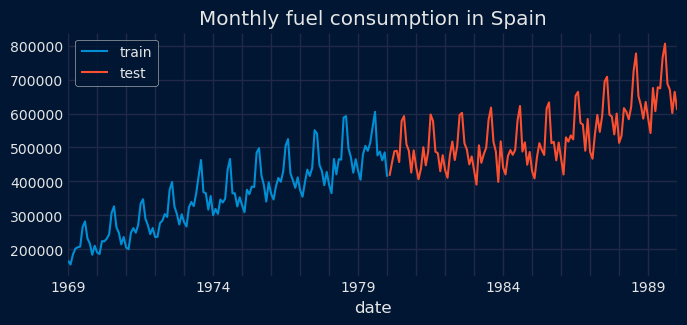

In [4]:
# Train-test dates
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

# Compare ets from skforecast, aeon, statsforecast and statsmodels

In [5]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1)
m = 12

In [6]:
estimator = Arima(
                    order=None,
                    seasonal_order=None,
                    m = m,
                    optim_method='BFGS',
                    optim_kwargs={'maxiter': 500},
                    trace=True,
                    max_p = 2,
                    max_q  = 2,
                )

estimator.fit(y=data_train['y'], suppress_warnings=True)
estimator.best_model_order_, estimator.best_seasonal_order_

 ARIMA(2,0,2)(1,1,1)[12] with drift         : 2682.1755
 ARIMA(0,0,0)(0,1,0)[12] with drift         : 2742.5688
 ARIMA(1,0,0)(1,1,0)[12] with drift         : 2712.1143
 ARIMA(0,0,1)(0,1,1)[12] with drift         : 2705.8477
 ARIMA(0,0,0)(0,1,0)[12]                    : 2872.0243
 ARIMA(2,0,2)(0,1,1)[12] with drift         : 2684.1871
 ARIMA(2,0,2)(1,1,0)[12] with drift         : Inf
 ARIMA(2,0,2)(2,1,1)[12] with drift         : Inf
 ARIMA(2,0,2)(1,1,2)[12] with drift         : 2680.9433
 ARIMA(2,0,2)(1,1,2)[12]                    : Inf
 ARIMA(2,0,2)(0,1,2)[12] with drift         : 2678.4496
 ARIMA(2,0,2)(0,1,2)[12]                    : Inf
 ARIMA(1,0,2)(0,1,2)[12] with drift         : 2681.2279
 ARIMA(2,0,1)(0,1,2)[12] with drift         : 2676.6913
 ARIMA(2,0,1)(0,1,2)[12]                    : Inf
 ARIMA(2,0,1)(0,1,1)[12] with drift         : 2682.2970
 ARIMA(2,0,1)(1,1,2)[12] with drift         : 2678.9840
 ARIMA(2,0,1)(1,1,1)[12] with drift         : 2680.4756
 ARIMA(1,0,1)(0,1,2)[1

((2, 0, 0), (0, 1, 2))

In [7]:
estimator.predict(steps=len(data_test))

array([418562.40974643, 491711.88227168, 496644.01011974, 505725.44463103,
       523716.03710661, 623592.15190345, 635513.67797637, 530827.60669312,
       518062.50777938, 479522.81331526, 513444.86675615, 466923.55304192,
       449031.83418625, 535282.50874426, 536489.32004991, 543538.37713569,
       558888.04460637, 637629.10518456, 665374.12174844, 548690.21517527,
       547307.24016544, 512978.71544031, 541538.05571799, 482426.656242  ,
       475589.63126195, 557096.80668566, 563031.11319988, 568356.73483796,
       585762.67478883, 663915.94730074, 692573.70222888, 575713.2894762 ,
       574745.02628212, 540379.43638208, 569132.09342807, 510024.94986502,
       503280.47944812, 584800.17135612, 590779.97796233, 596116.7175726 ,
       613545.58818049, 691706.75472276, 720376.32563794, 603521.01176828,
       602558.95412285, 568196.4959947 , 596952.4635308 , 537847.18674504,
       531104.50460428, 612625.28828519, 618606.07033923, 623943.44048574,
       641372.84713709, 7

In [10]:
estimator.predict_interval(steps=10)

,mean,lower_80,upper_80,lower_95,upper_95
step,,,,,
1,418562.409746,400143.805337,436981.014156,390393.585128,446731.234364
2,491711.882272,471233.217781,512190.546762,460392.467640,523031.296903
3,496644.010120,476067.683140,517220.337100,465175.233599,528112.786640
4,505725.444631,484664.852107,526786.037155,473516.047873,537934.841389
5,523716.037107,502604.719522,544827.354691,491429.063063,556003.011150
6,623592.151903,602355.438449,644828.865358,591113.401426,656070.902381
7,635513.677976,614255.378626,656771.977327,603001.914720,668025.441233
8,530827.606693,509535.126011,552120.087375,498263.567602,563391.645784
9,518062.507779,496761.776236,539363.239322,485485.850085,550639.165474


In [11]:
# ARIMA skforecast
# ==============================================================================
forecaster = ForecasterStats(
                estimator = Arima(
                    order=order,
                    seasonal_order=seasonal_order,
                    m = m,
                    optim_method='BFGS',
                    optim_kwargs={'maxiter': 1000}
                )
            )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_skforecast = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_skforecast} seconds")
start = timeit.default_timer()
predictions_skforecast = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_skforecast = end - start
prediction_intervals_skforecast = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ARIMA skforecast: {time_pred_arima_skforecast} seconds")

Training time ARIMA skforecast  : 0.11330629995791242 seconds


c:\Users\Joaquin\Documents\GitHub\skforecast\skforecast\stats\arima\_arima_base.py:2481: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
# ARIMA statsmodels
# ==============================================================================
seasonal_order_statsmodels = (
    seasonal_order[0],
    seasonal_order[1],
    seasonal_order[2],
    m if m > 1 else 0
)
forecaster = ForecasterStats(
                estimator = Sarimax(
                    order=order,
                    seasonal_order=seasonal_order_statsmodels
                )
            )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_statsmodels = end - start
print(f"Training time ARIMA skforecast  : {time_fit_arima_statsmodels} seconds")
start = timeit.default_timer()
predictions_statsmodels = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_statsmodels = end - start
prediction_intervals_statsmodels = forecaster.predict_interval(steps=24, alpha=0.05)
print(f"Prediction time ARIMA skforecast: {time_pred_arima_statsmodels} seconds")

In [ ]:
# ARIMA aeon
# ==============================================================================
# Aeeon ARIMA do not support seasonality nor prediction intervals
forecaster = ForecasterStats(
                 estimator=ARIMA_aeon(p=order[0], d=order[1], q=order[2])   
             )
start = timeit.default_timer()
forecaster.fit(y=data_train['y'])
end = timeit.default_timer()
time_fit_arima_aeon = end - start
print(f"Training time ARIMA aeon  : {time_fit_arima_aeon} seconds")
start = timeit.default_timer()
predictions_aeon = forecaster.predict(steps=24)
end = timeit.default_timer()
time_pred_arima_aeon = end - start
print(f"Prediction time ARIMA aeon: {time_pred_arima_aeon} seconds")

In [ ]:
# Nixtla StatsForecast Arima
# ==============================================================================
df_nixtla = data_train['y'].reset_index()
df_nixtla.columns = ['ds', 'y']
df_nixtla['unique_id'] = 'fuel'

start = timeit.default_timer()
sf = StatsForecast(
    models=[ARIMA_statsforecast(order=order, seasonal_order=seasonal_order, season_length=m)],
    freq='MS'
)
sf.fit(df=df_nixtla)
end = timeit.default_timer()
time_fit_arima_nixtla = end - start
print(f"Training time ARIMA nixtla  : {time_fit_arima_nixtla} seconds")

start = timeit.default_timer()
predictions_nixtla_df = sf.predict(h=24, level=[95])
end = timeit.default_timer()
time_pred_arima_nixtla = end - start

# Extract predictions and prediction intervals
predictions_nixtla = predictions_nixtla_df['ARIMA'].values
predictions_nixtla = pd.Series(predictions_nixtla, index=pd.date_range(start=data_test.index[0], periods=24, freq='MS'))

prediction_intervals_nixtla = pd.DataFrame({
    'lower_bound': predictions_nixtla_df['ARIMA-lo-95'].values,
    'upper_bound': predictions_nixtla_df['ARIMA-hi-95'].values
}, index=predictions_nixtla.index)

print(f"Prediction time ARIMA nixtla: {time_pred_arima_nixtla} seconds")

In [ ]:
# Table of times
# ==============================================================================
times_arima = pd.DataFrame({
    'fit_time_seconds': [time_fit_arima_skforecast, time_fit_arima_aeon, time_fit_arima_nixtla, time_fit_arima_statsmodels],
    'predict_time_seconds': [time_pred_arima_skforecast, time_pred_arima_aeon, time_pred_arima_nixtla, time_pred_arima_statsmodels]
}, index=['ARIMA skforecast', 'ARIMA aeon', 'ARIMA nixtla', 'ARIMA statsmodels'])
times_arima.sort_values(by='fit_time_seconds')

In [ ]:
# compare predictions
# ======================================================================================
predictions = pd.DataFrame({
    'skforecast': predictions_skforecast,
    'aeon'      : predictions_aeon,
    'nixtla'    : predictions_nixtla,
    'statsmodels': predictions_statsmodels
})
display(predictions.head(3))
predictions.plot(figsize=(7, 3), title='ARIMA predictions comparison');

In [ ]:
# Plot predictions with prediction intervals
# ======================================================================================
fig, ax = plt.subplots(figsize=(10, 5))

# Skforecast
predictions_skforecast.plot(ax=ax, label='predictions skforecast', color='C0', linewidth=2)
ax.fill_between(
    prediction_intervals_skforecast.index,
    prediction_intervals_skforecast['lower_bound'],
    prediction_intervals_skforecast['upper_bound'],
    color='C0',
    alpha=0.2,
    label='prediction interval skforecast (95%)'
)

# Nixtla
predictions_nixtla.plot(ax=ax, label='predictions nixtla', color='C2', linewidth=2)
ax.fill_between(
    prediction_intervals_nixtla.index,
    prediction_intervals_nixtla['lower_bound'],
    prediction_intervals_nixtla['upper_bound'],
    color='C2',
    alpha=0.2,
    label='prediction interval nixtla (95%)'
)

# Statsmodels
predictions_statsmodels.plot(ax=ax, label='predictions statsmodels', color='C1', linewidth=2)
ax.fill_between(
    prediction_intervals_statsmodels.index,
    prediction_intervals_statsmodels['lower_bound'],
    prediction_intervals_statsmodels['upper_bound'],
    color='C1',
    alpha=0.2,
    label='prediction interval statsmodels (95%)'
)

ax.set_title('ARIMA predictions with prediction intervals (95%)')
ax.legend();

In [ ]:
# Compare prediction interval widths
# ======================================================================================
interval_widths = pd.DataFrame({
    'skforecast': prediction_intervals_skforecast['upper_bound'] - prediction_intervals_skforecast['lower_bound'],
    'nixtla': prediction_intervals_nixtla['upper_bound'] - prediction_intervals_nixtla['lower_bound'],
    'statsmodels': prediction_intervals_statsmodels['upper_bound'] - prediction_intervals_statsmodels['lower_bound']
})

print("\nPrediction Interval Widths Summary (95% confidence):")
print("=" * 60)
print(interval_widths.describe().T[['mean', 'std', 'min', 'max']])
print("\nAverage interval width:")
print(interval_widths.mean().sort_values())

In [ ]:
# Backtesting ForecasterStats with Arima skforecast
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=Arima(
                     order=order,
                     seasonal_order=seasonal_order,
                     m=m
                 )
             )

start = timeit.default_timer()
metric_arima_skforecast, pred_arima_skforecast = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arima_skforecast = stop - start

In [ ]:
# Backtesting ForecasterStats Arima aeon
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=ARIMA_aeon(p=order[0], d=order[1], q=order[2])
             )

start = timeit.default_timer()
metric_arima_aeon, pred_arima_aeon = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arima_aeon = stop - start

In [ ]:
# Backtesting ForecasterStats Arima statsmodels
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(data_train),
        refit              = True,
        fixed_train_size   = False,
)
forecaster = ForecasterStats(
                 estimator=Sarimax(order=order, seasonal_order=seasonal_order_statsmodels)
             )

start = timeit.default_timer()
metric_arima_statsmodels, pred_arima_statsmodels = backtesting_stats(
    forecaster = forecaster,
    y          = data['y'],
    cv         = cv,
    metric     = 'mean_absolute_error'
)
stop = timeit.default_timer()
elapsed_time_arima_statsmodels = stop - start

In [ ]:
# Backtesting ForecasterStats with ETS nixtla
# ==============================================================================
# Note: Nixtla's StatsForecast doesn't integrate directly with skforecast's backtesting
# For a fair comparison, we would need to implement custom backtesting for nixtla
print("Note: Nixtla StatsForecast backtesting would require custom implementation")

In [ ]:
# Results
# ==============================================================================
results = pd.DataFrame(
    {
        "Model": [
            "Arima skforecast",
            "Arima aeon",
            "Arima statsmodels",
        ],
        "MAE": [
            
            metric_arima_skforecast.at[0, "mean_absolute_error"],
            metric_arima_aeon.at[0, "mean_absolute_error"],
            metric_arima_statsmodels.at[0, "mean_absolute_error"],
        ],
        "Elapsed Time (s)": [
            elapsed_time_arima_skforecast,
            elapsed_time_arima_aeon,
            elapsed_time_arima_statsmodels,
        ],
    }
)
results = results.sort_values(by="MAE").reset_index(drop=True)
results

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data['y'].loc[data_test.index].plot(ax=ax, label='y')
pred_arima_aeon['pred'].plot(ax=ax, label='pred_arima_aeon')
pred_arima_skforecast['pred'].plot(ax=ax, label='pred_arima_skforecast')
pred_arima_statsmodels['pred'].plot(ax=ax, label='pred_arima_statsmodels')
ax.set_title('Monthly fuel consumption in Spain - Predictions')
ax.legend();